In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import nn
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
from torch.utils.data import Dataset, DataLoader, random_split

class DigitTrainDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[idx, 0]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [3]:
train_path = "../input/digit-recognizer/train.csv"

train_dataset = DigitTrainDataset(train_path, transform=torchvision.transforms.ToTensor())
train_data_size = len(train_dataset)
train_dataset, validation_dataset = random_split(train_dataset, [int(0.8 * train_data_size), int(0.2 * train_data_size)])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

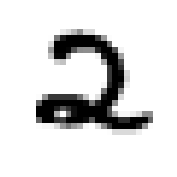

tensor([2])


In [4]:
import matplotlib.pyplot as plt

for img, label in train_dataloader:
    plt.figure(figsize=(3,3))
    plt.axis("off")
    plt.imshow(img.reshape(28, 28), cmap="binary")
    plt.show()
    print(label)
    break

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
import torch.nn.functional as F

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(2028, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = self.pool(output)
        output = output.view(-1, 2028)
        output = self.fc1(output)
        output = self.fc2(output)

        return output

model = MyNet().to(device)
print(model)

MyNet(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2028, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=7e-5)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(validation_dataloader, model, loss_fn)
print("Done!")

Epoch 1
---------------------
loss: 2.332526 [    0/33600]
loss: 1.993238 [  100/33600]
loss: 1.602531 [  200/33600]
loss: 0.669750 [  300/33600]
loss: 0.377696 [  400/33600]
loss: 0.339760 [  500/33600]
loss: 0.006203 [  600/33600]
loss: 1.321122 [  700/33600]
loss: 0.826666 [  800/33600]
loss: 0.304424 [  900/33600]
loss: 0.048294 [ 1000/33600]
loss: 0.001114 [ 1100/33600]
loss: 0.079715 [ 1200/33600]
loss: 0.076106 [ 1300/33600]
loss: 0.746818 [ 1400/33600]
loss: 0.116866 [ 1500/33600]
loss: 0.020810 [ 1600/33600]
loss: 0.085033 [ 1700/33600]
loss: 0.033050 [ 1800/33600]
loss: 0.236240 [ 1900/33600]
loss: 0.003337 [ 2000/33600]
loss: 0.030931 [ 2100/33600]
loss: 0.001180 [ 2200/33600]
loss: 0.000400 [ 2300/33600]
loss: 0.060188 [ 2400/33600]
loss: 0.079258 [ 2500/33600]
loss: 0.000186 [ 2600/33600]
loss: 0.056918 [ 2700/33600]
loss: 0.093681 [ 2800/33600]
loss: 0.012670 [ 2900/33600]
loss: 0.001333 [ 3000/33600]
loss: 0.003810 [ 3100/33600]
loss: 0.042260 [ 3200/33600]
loss: 0.00576

In [10]:
class DigitTestDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data.iloc[idx].values.astype(np.uint8).reshape((28, 28, 1))
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image

In [11]:
def test(dataloader, model, y_pred_output):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            y_pred = model(X).cpu().data.numpy().argmax()
            y_pred_output.append(y_pred)

In [12]:
test_path = "../input/digit-recognizer/test.csv"
test_dataset = DigitTestDataset(test_path, transform=torchvision.transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [13]:
y_pred_output = []
test(test_dataloader, model, y_pred_output)

In [14]:
sample = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
i = sample.ImageId

output = pd.DataFrame({'ImageId' : i, 'Label': y_pred_output})
output.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [15]:
output.to_csv('my_submission.csv', index=False)